# 6 Visualise laballed data and remove artefacts

Code that let us overlay each frame of video with outputs from the models. And create time series plots. 

In [4]:
import os
import cv2
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import utils
import display

In [5]:
videos_in = r"..\LookitLaughter.test"
metadata_file = "_LookitLaughter.xlsx"
data_out = r"..\data\1_interim"

#a couple of files for testing
VIDEO_FILE  = os.path.join(videos_in, "2UWdXP.joke1.rep2.take1.Peekaboo.mp4")
VIDEO_FILE2 = os.path.join(videos_in, "2UWdXP.joke2.rep1.take1.NomNomNom.mp4")

testset = [VIDEO_FILE, VIDEO_FILE2] 

In [6]:
processedvideos = utils.getprocessedvideos(data_out)
processedvideos.head()

found existing processedvideos.xlsx


,Unnamed: 0,Index,VideoID,ChildID,JokeType,JokeNum,JokeRep,JokeTake,HowFunny,LaughYesNo,...,Audio.file,Faces.when,Faces.file,LastError,Speech.file,Speech.when,Objects.file,Objects.when,Understand.file,Understand.when
0,0,0,2UWdXP.joke1.rep2.take1.Peekaboo.mp4,2UWdXP,Peekaboo,1,2,1,Slightly funny,No,...,..\data\1_interim\\2UWdXP.joke1.rep2.take1.Pee...,2023-09-24 07:52:41,..\data\1_interim\2UWdXP.joke1.rep2.take1.Peek...,NaN,..\data\1_interim\2UWdXP.joke1.rep2.take1.Peek...,2023-09-20 16:58:38,NaN,NaN,NaN,NaN
1,1,1,2UWdXP.joke1.rep3.take1.Peekaboo.mp4,2UWdXP,Peekaboo,1,3,1,Slightly funny,No,...,..\data\1_interim\\2UWdXP.joke1.rep3.take1.Pee...,2023-09-24 07:54:38,..\data\1_interim\2UWdXP.joke1.rep3.take1.Peek...,NaN,..\data\1_interim\2UWdXP.joke1.rep3.take1.Peek...,2023-09-20 16:58:39,NaN,NaN,NaN,NaN
2,2,2,2UWdXP.joke2.rep1.take1.NomNomNom.mp4,2UWdXP,NomNomNom,2,1,1,Funny,No,...,..\data\1_interim\\2UWdXP.joke2.rep1.take1.Nom...,2023-09-24 07:55:58,..\data\1_interim\2UWdXP.joke2.rep1.take1.NomN...,NaN,..\data\1_interim\2UWdXP.joke2.rep1.take1.NomN...,2023-09-20 16:58:40,NaN,NaN,NaN,NaN
3,3,3,2UWdXP.joke2.rep2.take1.NomNomNom.mp4,2UWdXP,NomNomNom,2,2,1,Slightly funny,No,...,..\data\1_interim\\2UWdXP.joke2.rep2.take1.Nom...,2023-09-24 07:56:57,..\data\1_interim\2UWdXP.joke2.rep2.take1.NomN...,NaN,..\data\1_interim\2UWdXP.joke2.rep2.take1.NomN...,2023-09-20 16:58:40,NaN,NaN,NaN,NaN
4,4,4,2UWdXP.joke2.rep3.take1.NomNomNom.mp4,2UWdXP,NomNomNom,2,3,1,Slightly funny,No,...,..\data\1_interim\\2UWdXP.joke2.rep3.take1.Nom...,2023-09-24 07:59:00,..\data\1_interim\2UWdXP.joke2.rep3.take1.NomN...,NaN,..\data\1_interim\2UWdXP.joke2.rep3.take1.NomN...,2023-09-20 16:58:48,NaN,NaN,NaN,NaN


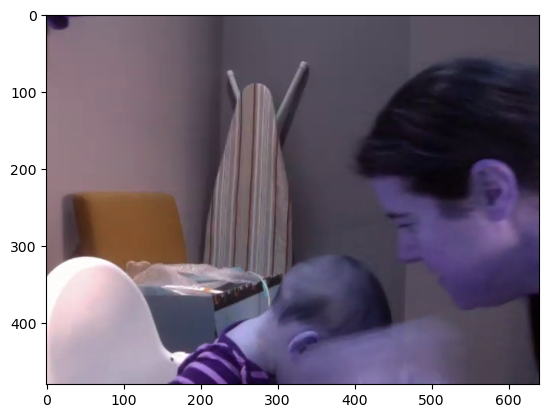

We have a keypoints file for this video
Empty DataFrame
Columns: [Unnamed: 0, frame, person, bboxcent.x, bboxcent.y, bbox.width, bbox.height, bbox.c, nose.x, nose.y, left_eye.x, left_eye.y, right_eye.x, right_eye.y, left_ear.x, left_ear.y, right_ear.x, right_ear.y, left_shoulder.x, left_shoulder.y, right_shoulder.x, right_shoulder.y, left_elbow.x, left_elbow.y, right_elbow.x, right_elbow.y, left_wrist.x, left_wrist.y, right_wrist.x, right_wrist.y, left_hip.x, left_hip.y, right_hip.x, right_hip.y, left_knee.x, left_knee.y, right_knee.x, right_knee.y, left_ankle.x, left_ankle.y, right_ankle.x, right_ankle.y, nose.c, left_eye.c, right_eye.c, left_ear.c, right_ear.c, left_shoulder.c, right_shoulder.c, left_elbow.c, right_elbow.c, left_wrist.c, right_wrist.c, left_hip.c, right_hip.c, left_knee.c, right_knee.c, left_ankle.c, right_ankle.c]
Index: []

[0 rows x 59 columns]


In [12]:
#let's grab a single frame from the video

framenum = 4
video = cv2.VideoCapture(VIDEO_FILE)
video.set(cv2.CAP_PROP_POS_FRAMES, framenum)
ret, frame = video.read()

if ret:
    plt.imshow(frame)
    plt.show()

#look in processed videos to see if we have a keypoints file for this video
videoname = os.path.basename(VIDEO_FILE)
videodata = processedvideos[processedvideos['VideoID'] == videoname]
if videodata.shape[0] > 0:
    print("We have a keypoints file for this video")
    kptsfile = videodata['Keypoints.file'].values[0]
    #Load the keypoints file
    kpts = pd.read_csv(kptsfile)
    kpts.head()

video.release()

In [23]:
print(f"kptsfile: {kptsfile}")

kpts.iloc[3]

kptsfile: ..\data\1_interim\2UWdXP.joke1.rep2.take1.Peekaboo.csv


Unnamed: 0            3.000000
frame                 3.000000
person                0.000000
bboxcent.x          517.692200
bboxcent.y          268.861542
bbox.width          244.291595
bbox.height         422.276947
bbox.c                0.519463
nose.x              451.206238
nose.y              312.775391
left_eye.x          467.204437
left_eye.y          267.338623
right_eye.x         454.171204
right_eye.y         275.966919
left_ear.x          572.157776
left_ear.y          238.928513
right_ear.x         519.890564
right_ear.y         258.796753
left_shoulder.x     583.715942
left_shoulder.y     429.665161
right_shoulder.x    599.972229
right_shoulder.y    384.976929
left_elbow.x        433.458069
left_elbow.y        480.000000
right_elbow.x       497.980957
right_elbow.y       403.488220
left_wrist.x        466.163879
left_wrist.y        420.827026
right_wrist.x       449.011017
right_wrist.y       421.169678
left_hip.x          566.985657
left_hip.y          480.000000
right_hi

In [30]:
framekpts = kpts[kpts['frame'] == 3]

#just need x,y coordinates, column 8 onwards
for row in framekpts.iterrows():
    print(row[1][8:].values)




[     451.21      312.78       467.2      267.34      454.17      275.97      572.16      238.93      519.89       258.8      583.72      429.67      599.97      384.98      433.46         480      497.98      403.49      466.16      420.83      449.01      421.17      566.99         480         594      478.11
      482.82      473.45      540.93      431.98      500.93      427.21      483.23      387.56      0.9509     0.98807     0.23554      0.9674   0.0029772     0.45176      0.2848    0.029976    0.021228     0.13011    0.098306   0.0020262   0.0027338   0.0029867   0.0039066   0.0029871   0.0041373]


In [2]:
frame = display.drawOneFrame(frame, kpts)

AttributeError: 'function' object has no attribute 'drawOneFrame'